In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import opendp.prelude as dp
dp.enable_features("contrib")

/Users/Ava/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/Ava/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# County Level

In [2]:
agg_county_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/agg_commute_county_level_all.csv")
county_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/commute_county_level_all.csv")

In [3]:
county_categories = agg_county_data_df['County_commute'].unique()
len(county_categories) # MUST TAKE FROM DATA WHERE CATEGORIES CAN HAVE COUNT 0 ie.not where each individual is row

1085

In [4]:
col_names = ["County_commute","County_Origin","County_Destination"]
size = len(county_data_df) #Number of individuals in dataset
county_categories = list(county_categories) #Number of possible categories 


In [5]:
with open('commute_county_level_all.csv') as input_data:
    county_data = input_data.read()

In [6]:
def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    #plt.ylim([0,20000])
    
    tick_spacing = 1.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #plt.xlim(0,1084)
    width = .4

    ax.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    ax.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')

    ax.legend()
    plt.xticks([])  
    plt.title('Histogram of Counts after Laplace Mechanism for County Level Commute')
    plt.xlabel('Commute')
    plt.ylabel('Count')
    plt.show()

In [7]:
max_influence = 2
budget = np.arange(0.5,5.5, 0.5)

In [8]:
histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="County_commute", TOA=str) >>
    # Compute counts for each of the categories
    dp.t.then_count_by_categories(categories=county_categories)
)

county_sensitive_counts = histogram(county_data)

# empty dictionary
all_county_released_counts = []
all_county_elapsed_time = []


for epsilon in budget:
    #d_in is the sensistivity 
    #d_out is the privacy budget ie.epsilon
    noisy_histogram = dp.binary_search_chain(
        lambda s: histogram >> dp.m.then_laplace(scale=s),
        d_in=max_influence, d_out=epsilon)

    start_time = time.time()
    released_counts = noisy_histogram(county_data)
    end_time = time.time()

    elapsed_time = end_time - start_time
    all_county_elapsed_time.append(elapsed_time)

    # Post-processing to ensure non-negative counts
    released_counts = [max(count, 0) for count in released_counts]
    all_county_released_counts.append(released_counts)



In [9]:
print("Educational level counts:\n", county_sensitive_counts[:-1])
print("DP Educational level counts:\n", all_county_released_counts[0][:-1])

print("DP estimate for the number of records that were not a member of the category set:", released_counts[-1])

Educational level counts:
 [19174, 962, 548, 132, 290, 1251, 1512, 984, 28, 12, 958, 1054, 40, 39, 9, 76, 248, 46, 12, 9, 8, 1978, 6, 1626, 52, 14, 13, 17, 3, 28, 3, 8, 6, 1, 0, 92, 218860, 15302, 22668, 19235, 3056, 41, 71, 1141, 60, 50, 796, 113, 108, 31, 140, 58, 139, 47, 32, 34, 17955, 177, 6548, 62, 369, 53, 142, 26, 518, 35, 31, 32, 33, 8, 84, 44145, 80723, 5199, 12769, 4526, 36, 57, 563, 30, 35, 818, 49, 73, 25, 67, 41, 68, 26, 18, 26, 10631, 61, 2914, 72, 125, 20, 127, 9, 172, 18, 23, 27, 16, 9, 54, 56998, 5941, 91167, 4872, 2236, 22, 29, 3470, 36, 35, 273, 47, 82, 18, 95, 43, 72, 33, 38, 59, 10995, 124, 4410, 36, 1025, 39, 124, 10, 220, 17, 32, 27, 16, 1, 45, 41779, 6154, 2150, 66937, 974, 25, 28, 233, 17, 58, 2979, 54, 62, 12, 72, 25, 84, 26, 15, 16, 6420, 69, 4835, 25, 93, 12, 62, 8, 240, 15, 9, 10, 10, 3, 1701, 18313, 11759, 3645, 3572, 80682, 320, 906, 1285, 973, 57, 1293, 71, 111, 30, 203, 135, 185, 37, 17, 30, 8673, 60, 4465, 120, 87, 21, 336, 27, 176, 34, 37, 41, 27, 4,

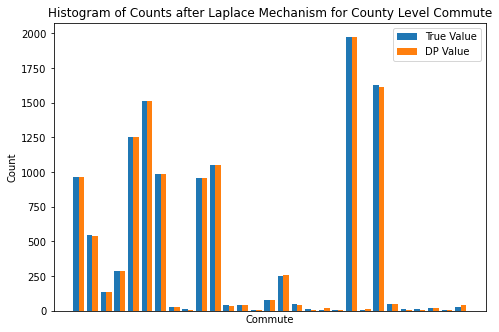

In [10]:
plot_histogram(county_sensitive_counts[1:30], all_county_released_counts[0][1:30])
#plt.savefig("Histogram of Counts after Laplace Mechanism")


In [11]:
def calculate_rmse(predicted_values, actual_values):    
    # Calculate the squared differences
    squared_diffs = np.square(np.array(predicted_values) - np.array(actual_values))
    
    # Calculate the mean of squared differences
    mean_squared_diff = np.mean(squared_diffs)
    
    # Take the square root to get RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse


In [12]:
all_county_rmse  =[]
for released_count in range(len(budget)):
    rmse = calculate_rmse(all_county_released_counts[released_count], county_sensitive_counts)
    all_county_rmse.append(rmse)


In [13]:
all_county_rmse
budget

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

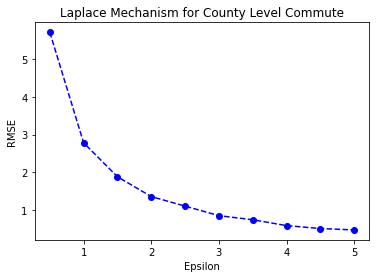

In [14]:
plt.plot(budget, all_county_rmse, 'bo')
plt.plot(budget, all_county_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('Laplace Mechanism for County Level Commute')
plt.savefig("Laplace Mechanism for County Level Commute")

In [18]:
#Maximum error 
all_county_max_count_difference = []
all_county_max_count_difference_index = []
for released_count in range(len(budget)):
    max_county_count_difference = max(abs(all_county_released_counts[released_count][idx] - county_sensitive_counts[idx]) for idx in range(len(county_sensitive_counts)))
    all_county_max_count_difference.append(max_county_count_difference)
    county_max_count_difference_index = [idx for idx in range(len(county_sensitive_counts)) if abs(all_county_released_counts[released_count][idx] - county_sensitive_counts[idx]) == max_county_count_difference]
    all_county_max_count_difference_index.append(county_max_count_difference_index)


In [21]:
all_county_max_count_difference
#[28, 14, 8, 7, 6, 6, 4, 3, 3, 3]
all_county_max_count_difference_index
# [[601],
#  [555],
#  [194, 522, 572],
#  [538],
#  [403],
#  [215],
#  [518, 686],
#  [112, 124, 258, 415, 592, 1050],
#  [933],
#  [716]]

[[618],
 [29],
 [52, 854],
 [674, 753],
 [993],
 [93, 128, 685, 860, 1017],
 [725],
 [681],
 [465, 555],
 [465]]

In [22]:
county_mean_time  = np.mean(all_county_elapsed_time)
county_mean_time # in seconds 
#5.557075667381286

6.358440613746643

In [23]:
all_county_elapsed_time

#[5.961507081985474,
#  5.719324111938477,
#  5.47859001159668,
#  5.477495193481445,
#  5.45618200302124,
#  5.492994785308838,
#  5.506938695907593,
#  5.485191106796265,
#  5.466466903686523,
#  5.526066780090332]

[7.331993103027344,
 6.701935768127441,
 5.898215293884277,
 5.784113883972168,
 6.042531251907349,
 5.77241325378418,
 6.719473838806152,
 6.638479948043823,
 6.815895080566406,
 5.87935471534729]

# ED Level

In [24]:
agg_ed_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/agg_commute_ed_level_all.csv")
ed_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/commute_ed_level_all.csv")

In [25]:
ed_categories = agg_ed_data_df['ED_Commute'].unique()
len(ed_categories) # MUST TAKE FROM DATA WHERE CATEGORIES CAN HAVE COUNT 0 ie.not where each individual is row

8699658

In [26]:
col_names = ["ED_commute","ED_Origin","ED_Destination"]
size = len(ed_data_df) #Number of individuals in dataset
ed_categories = list(ed_categories) #Number of possible categories 

In [27]:
with open('commute_ed_level_all.csv') as input_data:
    ed_data = input_data.read()

In [20]:
len(budget)

10

In [23]:
histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="ED_commute", TOA=str) >>
    # Compute counts for each of the categories
    dp.t.then_count_by_categories(categories=ed_categories)
)

ed_sensitive_counts = histogram(ed_data)

# empty dictionary
all_ed_released_counts = []
all_ed_elapsed_time = []

for i, epsilon in enumerate(budget):
    #d_in is the sensistivity 
    #d_out is the privacy budget ie.epsilon
    noisy_histogram = dp.binary_search_chain(
        lambda s: histogram >> dp.m.then_laplace(scale=s),
        d_in=max_influence, d_out=epsilon)

    start_time = time.time()
    released_counts = noisy_histogram(ed_data)
    end_time = time.time()

    elapsed_time = end_time - start_time
    all_ed_elapsed_time.append(elapsed_time)

    # Post-processing to ensure non-negative counts
    released_counts = [max(count, 0) for count in released_counts]
    all_ed_released_counts.append(released_counts)
    print(f'{(i+1)/len(budget)} Completed.', end = '\r')

In [24]:
all_ed_rmse  =[]
for released_count in range(len(budget)):
    rmse = calculate_rmse(all_ed_released_counts[released_count], ed_sensitive_counts)
    all_ed_rmse.append(rmse)


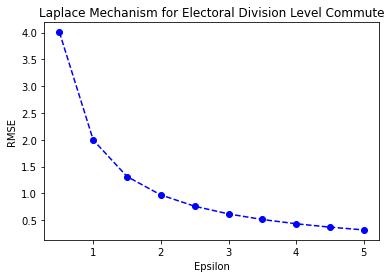

In [26]:
plt.plot(budget, all_ed_rmse, 'bo')
plt.plot(budget, all_ed_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('Laplace Mechanism for Electoral Division Level Commute')
plt.savefig("Laplace Mechanism for Electoral Division Level Commute")


In [45]:
#Maximum error 
all_ed_max_count_difference = []
all_ed_max_count_difference_index = []
for released_count in range(len(budget)):
    max_ed_count_difference = max(abs(all_ed_released_counts[released_count][idx] - ed_sensitive_counts[idx]) for idx in range(len(ed_sensitive_counts)))
    all_ed_max_count_difference.append(max_ed_count_difference)
    ed_max_count_difference_index = [idx for idx in range(len(ed_sensitive_counts)) if abs(all_ed_released_counts[released_count][idx] - ed_sensitive_counts[idx]) == max_ed_count_difference]
    all_ed_max_count_difference_index.append(ed_max_count_difference_index)


In [46]:
all_ed_max_count_difference
#[57, 32, 21, 16, 12, 10, 10, 8, 7, 6]
all_ed_max_count_difference_index
# [[7890592],
#  [8426434],
#  [1638498],
#  [573781],
#  [691995, 3917674],
#  [5692415, 7269616],
#  [704791, 4168329, 4707089],
#  [5636043],
#  [2651429, 6328040],
#  [2327384, 2887713, 5594075, 5839875]]

[[7890592],
 [8426434],
 [1638498],
 [573781],
 [691995, 3917674],
 [5692415, 7269616],
 [704791, 4168329, 4707089],
 [5636043],
 [2651429, 6328040],
 [2327384, 2887713, 5594075, 5839875]]

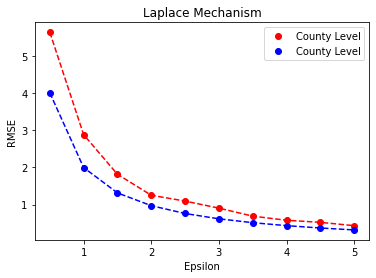

In [29]:
plt.plot(budget, all_county_rmse, 'ro', label='County Level')
plt.plot(budget, all_county_rmse, 'r--')

plt.plot(budget, all_ed_rmse, 'bo', label='County Level')
plt.plot(budget, all_ed_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('Laplace Mechanism')
plt.legend(loc="upper right")
plt.savefig("Laplace Mechanism")

In [32]:
all_ed_elapsed_time
# [414.3674931526184,
#  332.5656387805939,
#  333.07225608825684,
#  320.9939818382263,
#  320.56924319267273,
#  333.8113238811493,
#  360.2779760360718,
#  332.6513411998749,
#  335.4997880458832,
#  435.3151710033417]

[414.3674931526184,
 332.5656387805939,
 333.07225608825684,
 320.9939818382263,
 320.56924319267273,
 333.8113238811493,
 360.2779760360718,
 332.6513411998749,
 335.4997880458832,
 435.3151710033417]

In [30]:
ed_mean_time  = np.mean(all_ed_elapsed_time)
ed_mean_time # in seconds 
#351.9124213218689

351.9124213218689

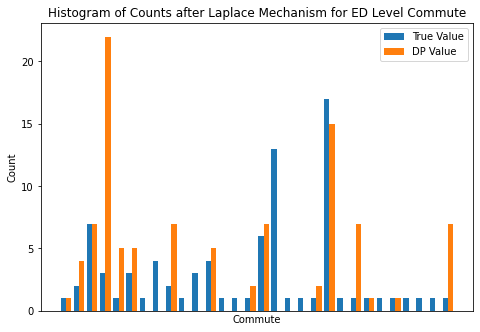

<Figure size 432x288 with 0 Axes>

In [52]:
plot_histogram(ed_sensitive_counts[100:130], all_ed_released_counts[0][100:130])
#plt.savefig("Histogram of Counts after Laplace Mechanism for ED")



In [60]:
print(ed_data[100:130])

ban
Carlow Urban-Carlow Urban,


In [32]:
#print("Sensitive Counts :/n", ed_sensitive_counts[100:130])
#print("Released Counts :/n", all_ed_released_counts[0][100:130])
print("ed_categories :/n", ed_categories[100:130])
#ed_categories :/n ['Carlow Urban-Kilcock', 'Carlow Urban-Leixlip', 'Carlow Urban-Maynooth', 'Carlow Urban-Ballysax East', 'Carlow Urban-Carnalway', 'Carlow Urban-Droichead Nua (Newbridge) Urban', 'Carlow Urban-Kilcullen', 'Carlow Urban-Kildare', 'Carlow Urban-Kill', 'Carlow Urban-Killashee', 'Carlow Urban-Ladytown', 'Carlow Urban-Morristownbiller', 'Carlow Urban-Naas Rural', 'Carlow Urban-Oldconnell', 'Carlow Urban-Rathmore', 'Carlow Urban-Kilkenny No. 1 Urban', 'Carlow Urban-Kilkenny No. 2 Urban', 'Carlow Urban-Ballyragget', 'Carlow Urban-Castlecomer', 'Carlow Urban-Gowran', 'Carlow Urban-Kilkenny Rural', 'Carlow Urban-Shankill', 'Carlow Urban-Ballyhale', 'Carlow Urban-Goresbridge', 'Carlow Urban-Graiguenamanagh', 'Carlow Urban-Stonyford', 'Carlow Urban-Kilculliheen (part)', 'Carlow Urban-Rathpatrick', 'Carlow Urban-Abbeyleix', 'Carlow Urban-Ballinakill']

ed_categories :/n ['Carlow Urban-Kilcock', 'Carlow Urban-Leixlip', 'Carlow Urban-Maynooth', 'Carlow Urban-Ballysax East', 'Carlow Urban-Carnalway', 'Carlow Urban-Droichead Nua (Newbridge) Urban', 'Carlow Urban-Kilcullen', 'Carlow Urban-Kildare', 'Carlow Urban-Kill', 'Carlow Urban-Killashee', 'Carlow Urban-Ladytown', 'Carlow Urban-Morristownbiller', 'Carlow Urban-Naas Rural', 'Carlow Urban-Oldconnell', 'Carlow Urban-Rathmore', 'Carlow Urban-Kilkenny No. 1 Urban', 'Carlow Urban-Kilkenny No. 2 Urban', 'Carlow Urban-Ballyragget', 'Carlow Urban-Castlecomer', 'Carlow Urban-Gowran', 'Carlow Urban-Kilkenny Rural', 'Carlow Urban-Shankill', 'Carlow Urban-Ballyhale', 'Carlow Urban-Goresbridge', 'Carlow Urban-Graiguenamanagh', 'Carlow Urban-Stonyford', 'Carlow Urban-Kilculliheen (part)', 'Carlow Urban-Rathpatrick', 'Carlow Urban-Abbeyleix', 'Carlow Urban-Ballinakill']
